In [1]:
import gpytorch
import numpy as np
import pandas as pd
import torch

from bo_functions import ExactGPModel
from bo_functions import create_y_data
from bo_functions import bo_iter
from bo_functions import test_train_split
from bo_functions import bo_iter_w_runs
from bo_functions import find_train_doc_path
from datetime import datetime

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Set Date and Time
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
print("Date and Time: ", timestampStr)
# DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M-%S%p")
DateTime = None ##For Testing

#Set Parameters
Theta_True = np.array([1,-1])
BO_iters = 3
train_iter = 300
noise_std = 0.1
runs = 2
explore_bias = torch.tensor([0.75])
explore_bias = torch.tensor([0])

sep_fact = 1
shuffle_seed = 9
set_lengthscale = None
t= 100
emulator = True
sparse_grid = False
verbose = True
save_fig = False

#Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/n=5.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
n = len(Xexp)

#Define GP Testing space
p=20
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays

Date and Time:  04-Aug-2022 (16:02:48)


Runs: 2
BO Iters: 3
----------------------------------------------------
Separation Factor Train/Test: 1
Lengthscale Set To: None
Initial Explore Bias: 0.0
Run Number:  1


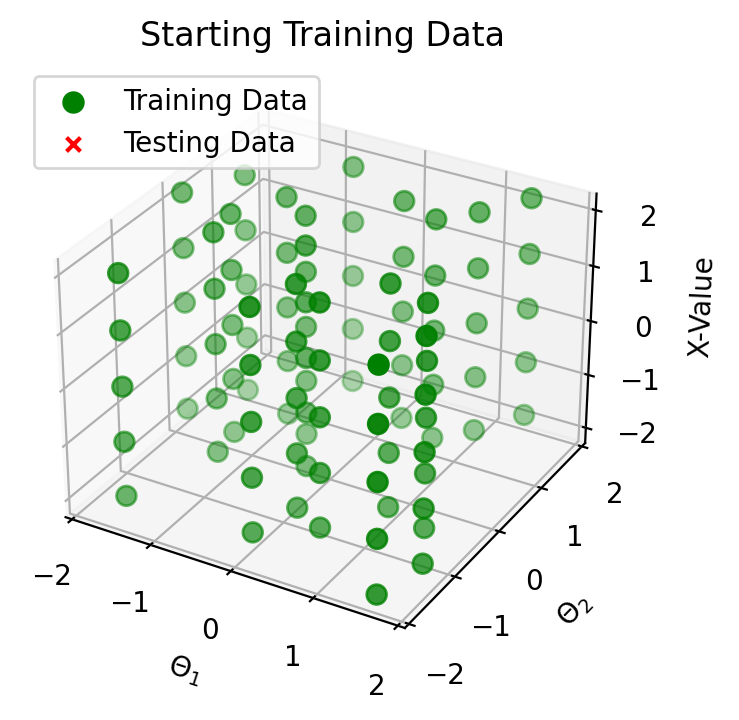

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution
/scratch365/mcarlozo/Toy_Problem/bo_functions.py:850: RuntimeWarning: invalid value encountered in sqrt
  SSE_stdev_GP[i,j] = np.sqrt(SSE_var_GP[i,j])


[[3.01956677 3.22188902 3.38158035 3.49279022 3.60392594 3.75518751
  3.96232319 4.23652983 4.58565092 4.99156284 5.36463118 5.53078604
  5.36711264 4.96827364 4.56934357 4.33902788 4.30129576 4.38679218
  4.54594421 4.88074875]
 [3.05050159 3.28799963 3.48612833 3.63130546 3.7806046  3.97888255
  4.24162006 4.58518934 5.02337694 5.52651548 5.95040178 6.05040073
  5.73632145 5.24223471 4.8694334  4.72898197 4.76626015 4.86791992
  4.95938587 5.16872501]
 [2.99229932 3.22477579 3.43635845 3.61005974 3.79392219 4.02960014
  4.33298588 4.72624969 5.2359581  5.84720469 6.41081095 6.63723803
  6.40277863 5.96808004 5.65022659 5.53501225 5.55208015 5.60087395
  5.63047171 5.78121185]
 [2.87535429 3.07146144 3.26864386 3.45236754 3.65127969 3.89954829
  4.21496439 4.62233973 5.16131735 5.85873222 6.64342213 7.26177311
  7.4478097  7.23935366 6.8972578  6.60253239 6.39959908 6.2870307
  6.29764414 6.53847408]
 [2.74595928 2.89812779 3.06785393 3.24661303 3.44496703 3.68532801
  3.98740625 4.37

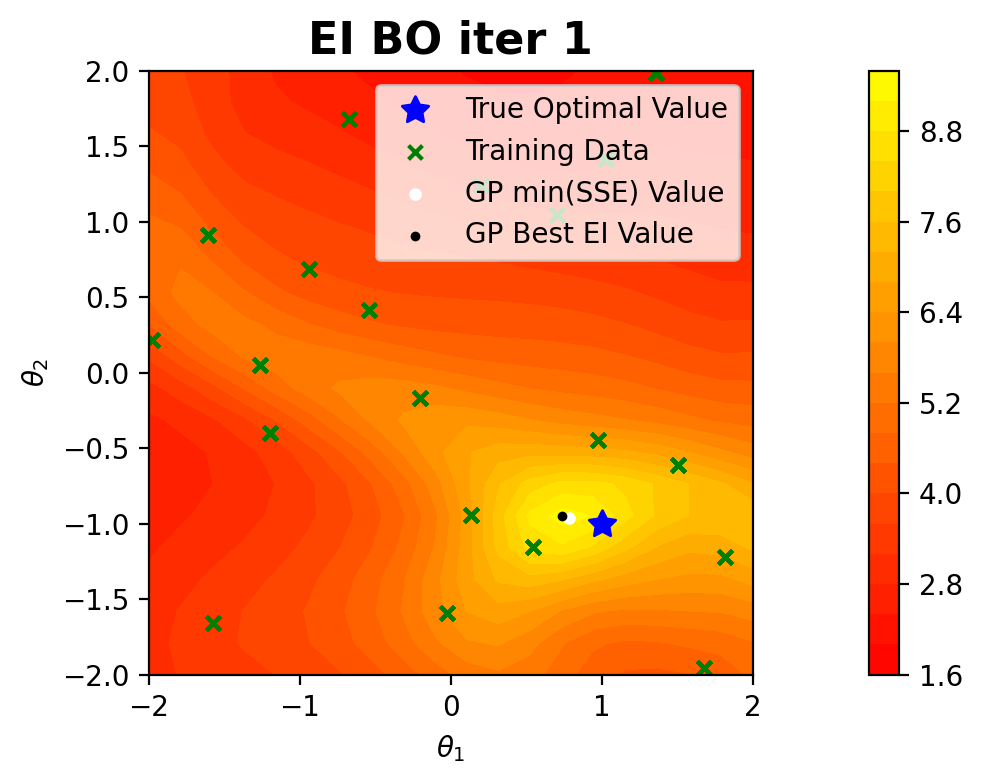

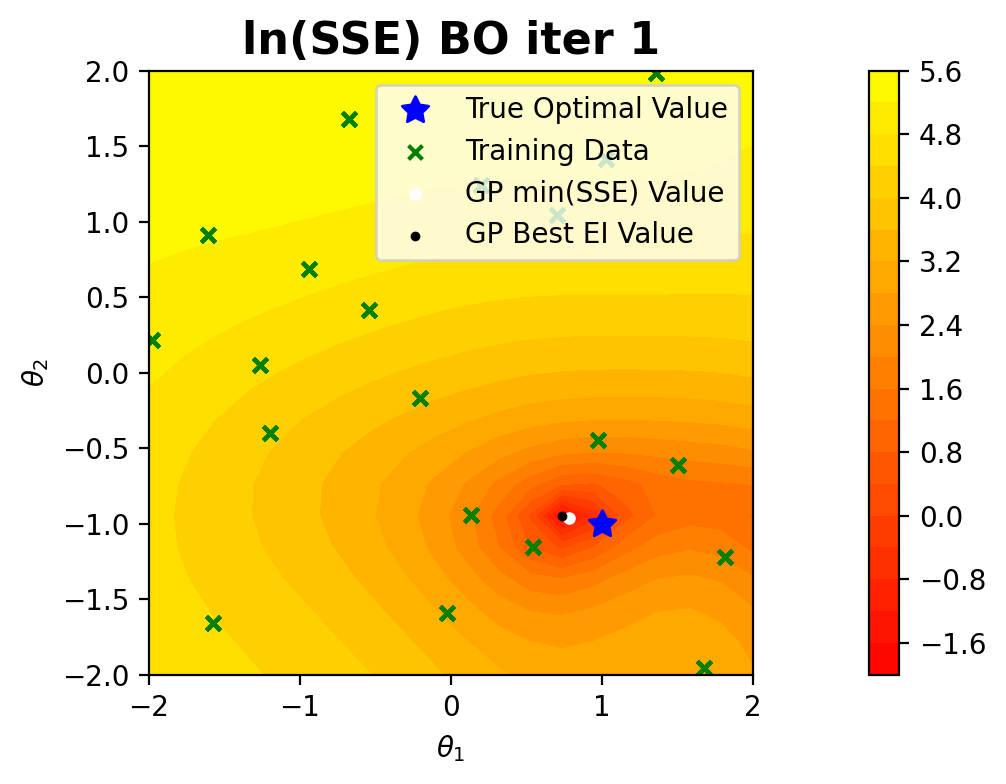

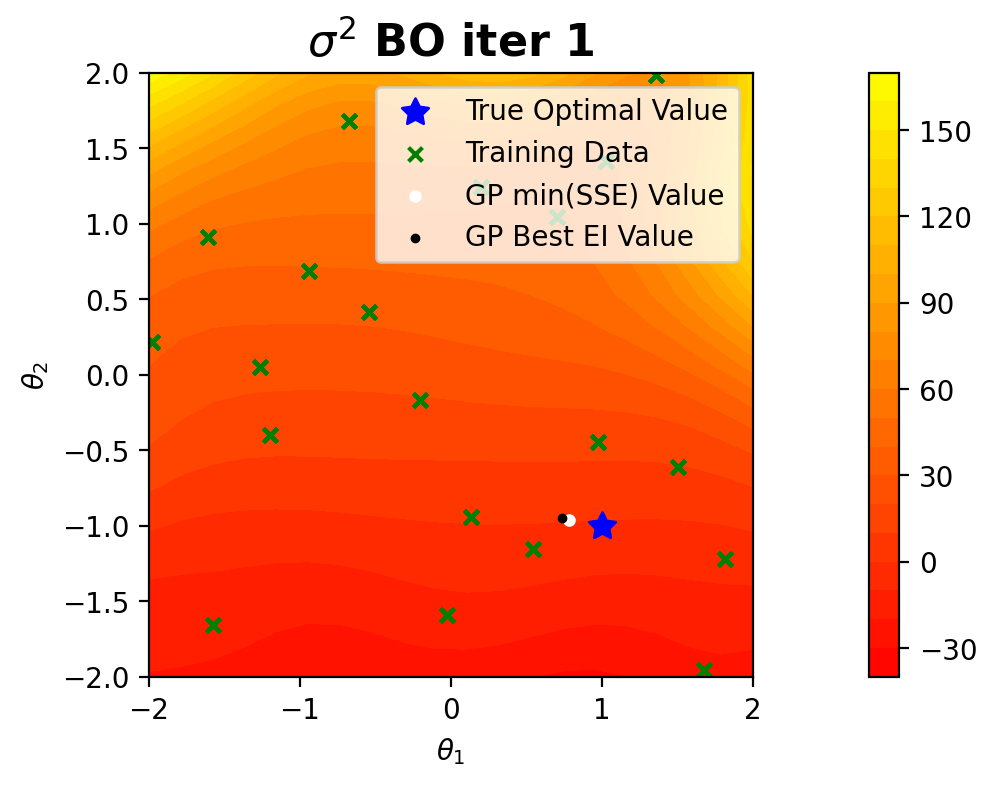

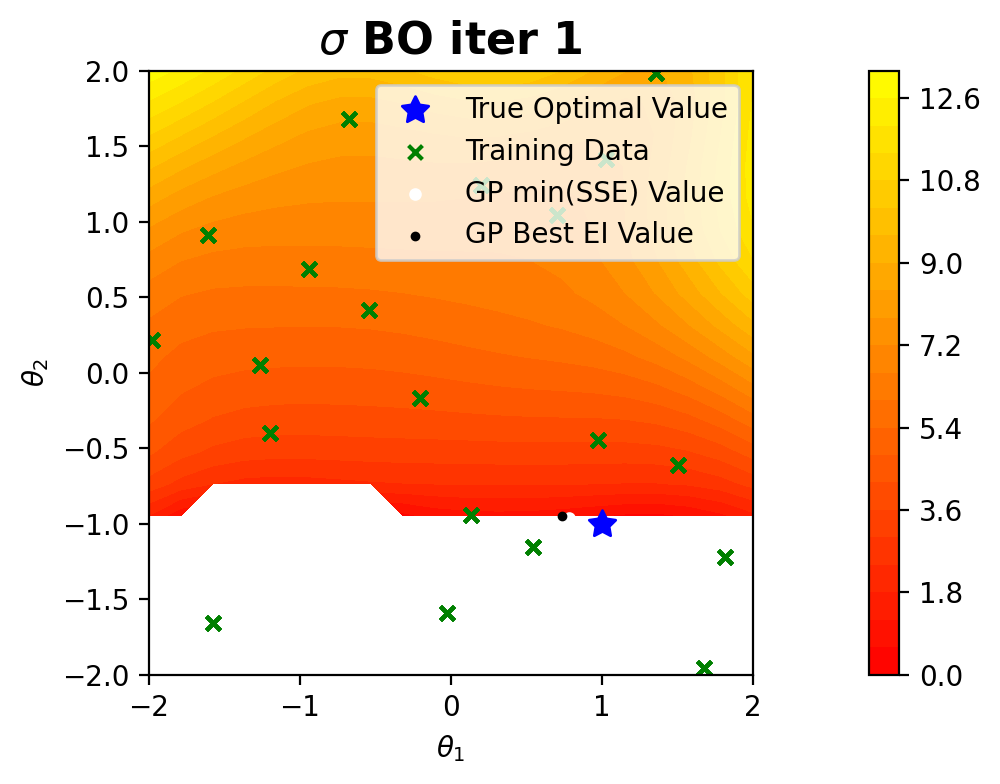

Best Error is: 2.8225
Magnitude of ln(SSE) given Theta_Opt =  [ 0.78260045 -0.96536033] is -7.0104e-01
[[0.42497188 0.49364588 0.55604458 0.62018836 0.72250479 0.85005599
  0.98285174 1.12750852 1.26798439 1.32291508 1.2103169  1.00444829
  0.84460008 0.76673418 0.73955917 0.75465763 0.83770782 0.978477
  1.03944266 0.92191213]
 [0.42714086 0.51366067 0.57475495 0.61574727 0.7240966  0.89181536
  1.06652153 1.25791466 1.45956504 1.56221306 1.42278552 1.15650702
  0.97857761 0.8989175  0.86593461 0.88161302 0.97018212 1.10590124
  1.15526879 1.05104923]
 [0.40989831 0.50024354 0.5648576  0.57822973 0.63283384 0.77089751
  0.94561368 1.14789832 1.39640963 1.64832008 1.70615721 1.46439934
  1.21995687 1.12134004 1.08021057 1.08951128 1.18110693 1.33441043
  1.42438471 1.32607746]
 [0.38310778 0.45934057 0.52299994 0.53942096 0.55386287 0.61404628
  0.71877074 0.85339528 1.0279789  1.28400564 1.63455093 1.84403038
  1.65992689 1.45483804 1.44361639 1.55187702 1.69751573 1.74891448
  1.6576

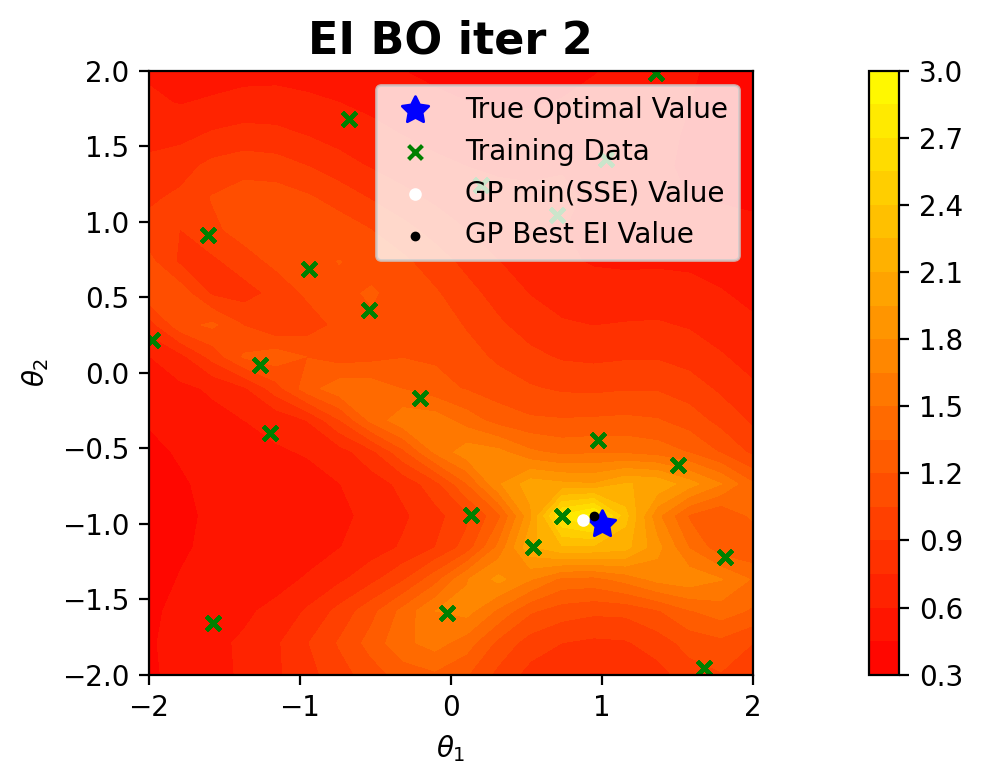

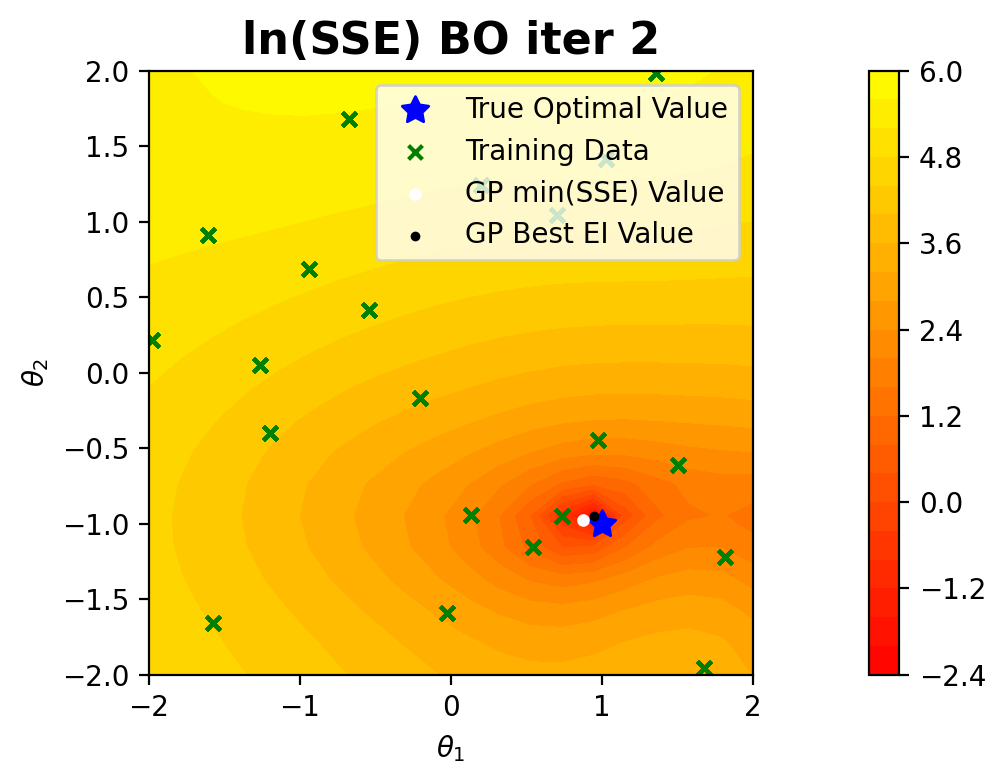

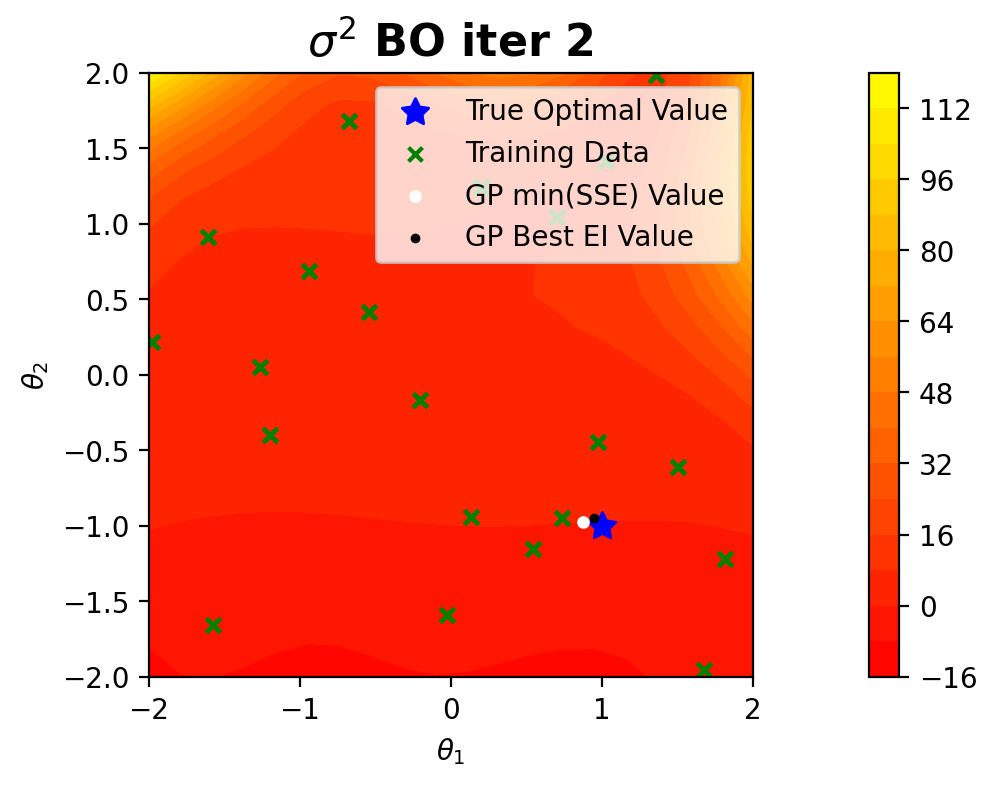

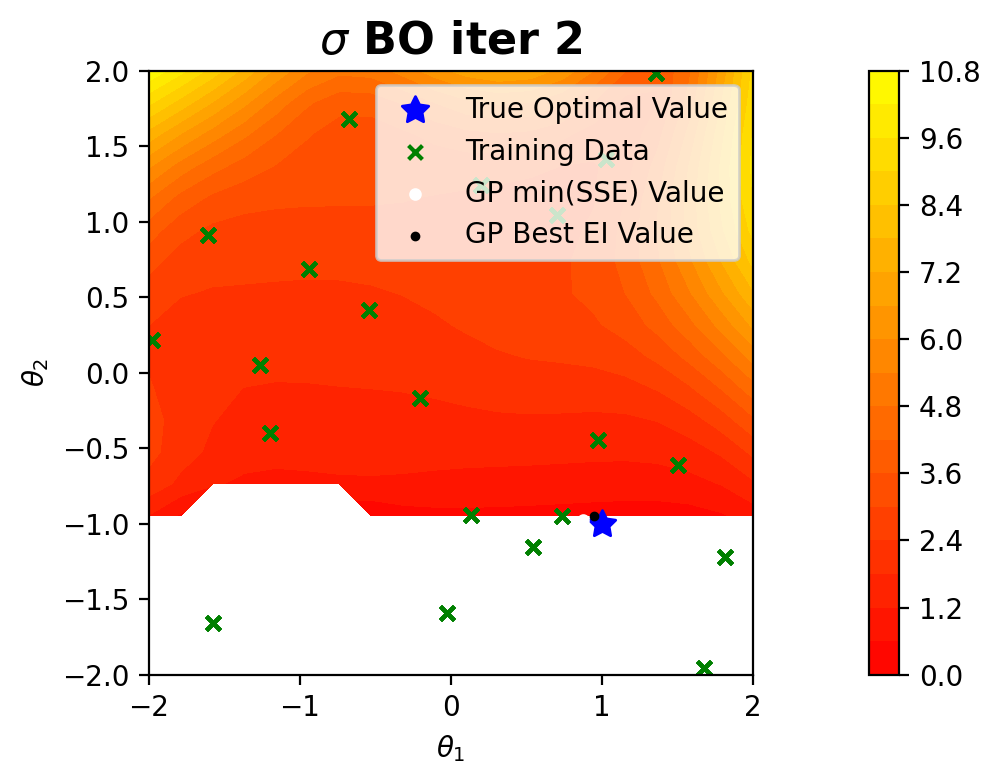

Best Error is: 0.768
Magnitude of ln(SSE) given Theta_Opt =  [ 0.87820819 -0.97763124] is -1.8538e+00
[[0.03333804 0.04516673 0.05086499 0.04774654 0.05610415 0.07653896
  0.09850527 0.12007445 0.13196521 0.12730008 0.11340648 0.09391233
  0.07784589 0.06725269 0.0625677  0.06769697 0.08598565 0.11917277
  0.1507313  0.11124836]
 [0.03740441 0.06362186 0.08752088 0.06829695 0.05742235 0.0738429
  0.10323656 0.13630243 0.15453687 0.15122095 0.16100755 0.13767661
  0.10632765 0.08395992 0.0756298  0.08468714 0.11210316 0.16496056
  0.19471616 0.12896073]
 [0.03675437 0.06248898 0.09833252 0.08287925 0.063636   0.06033464
  0.07509357 0.10721776 0.16417822 0.20683824 0.17465413 0.18093456
  0.15711114 0.11779772 0.09819444 0.11160634 0.14951868 0.18969773
  0.17448705 0.13873848]
 [0.0340456  0.05190302 0.07677585 0.07981847 0.0677707  0.06160384
  0.06295741 0.07139784 0.08647723 0.10767625 0.17410593 0.24721512
  0.2001261  0.18167575 0.14691503 0.15905891 0.18729708 0.23564985
  0.2125

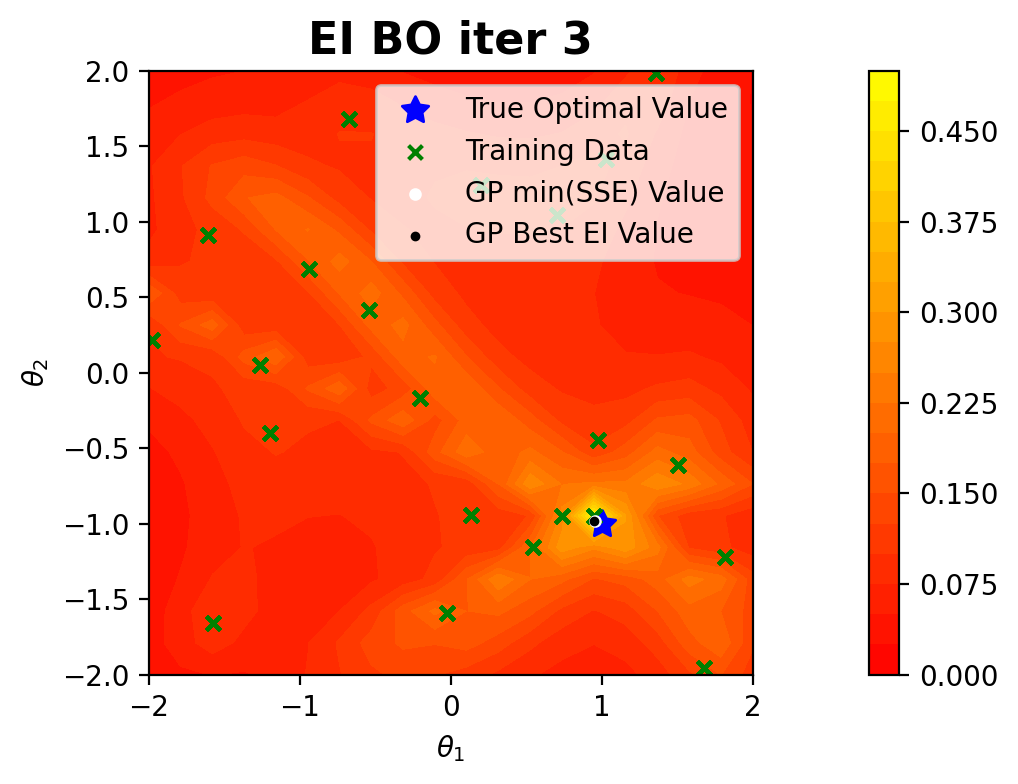

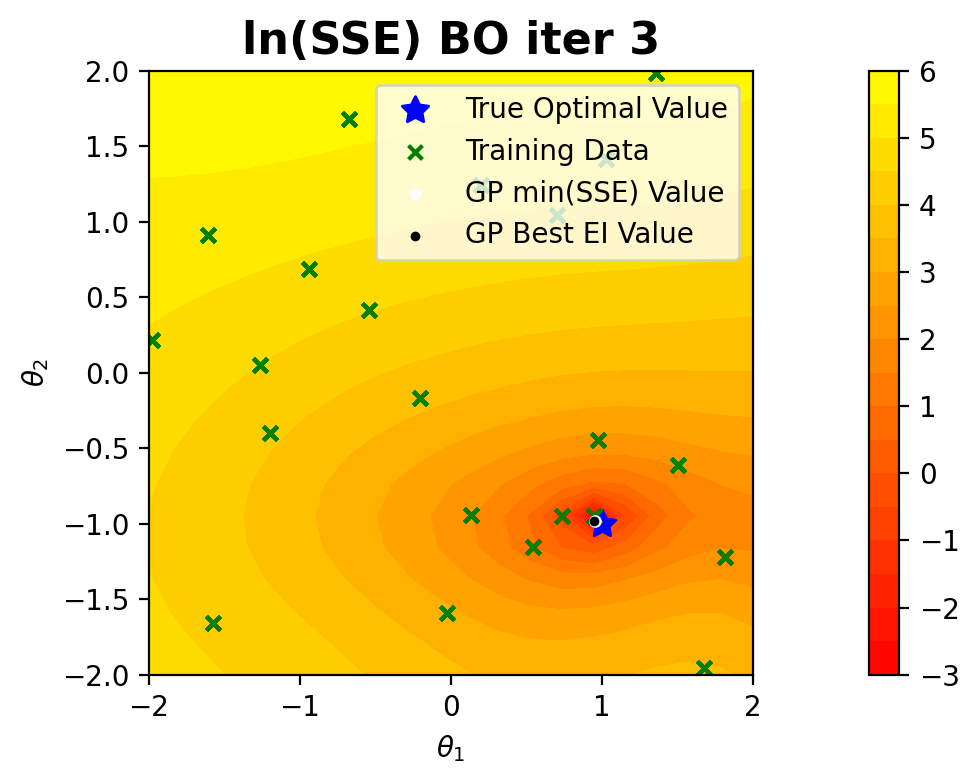

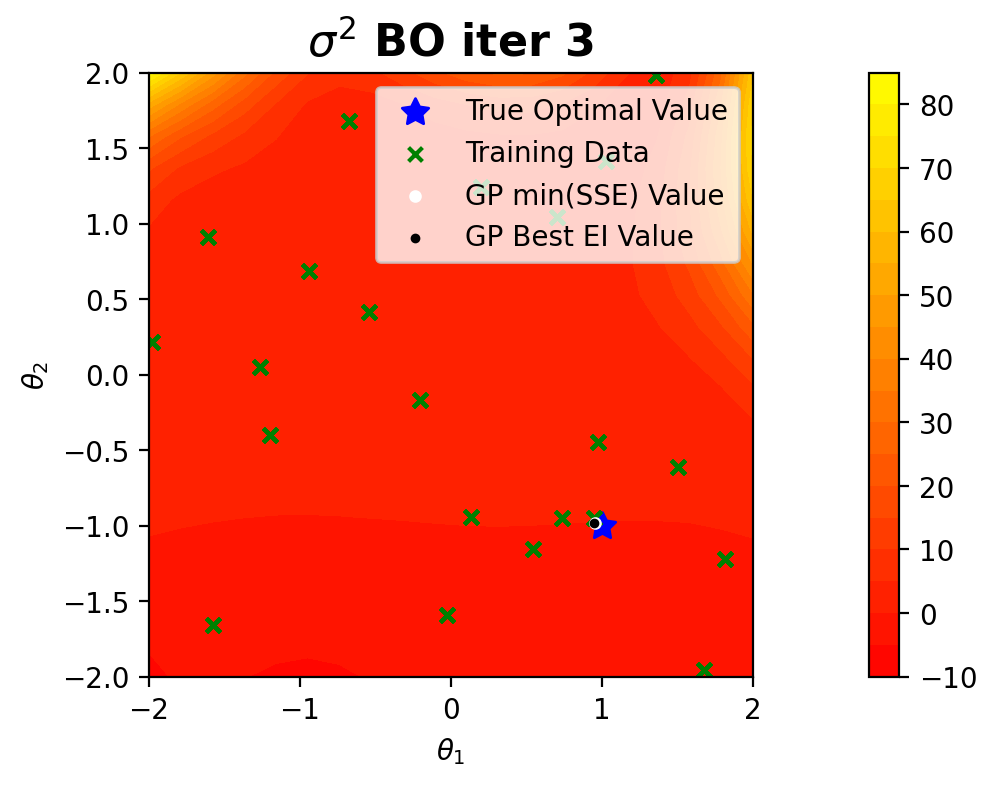

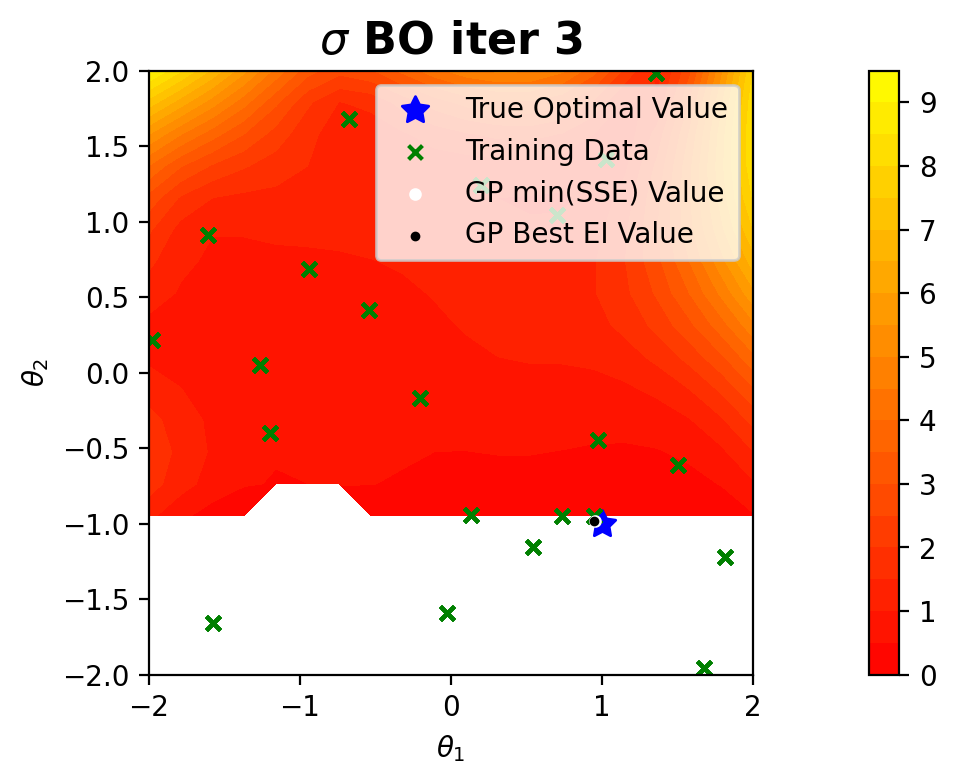

Best Error is: 0.1283
Magnitude of ln(SSE) given Theta_Opt =  [ 0.95530622 -0.985481  ] is -3.6548e+00
Run Number:  2


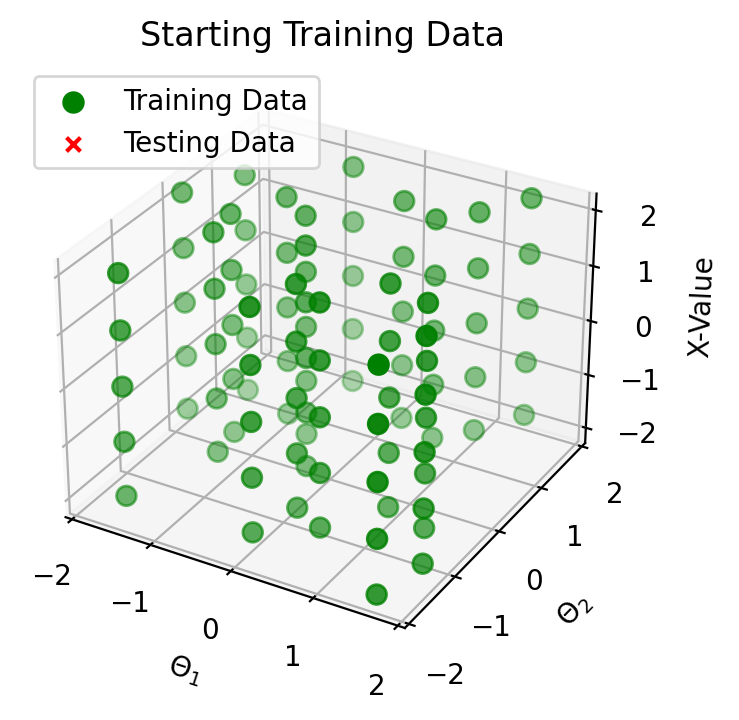

[[3.01956677 3.22188902 3.38158035 3.49279022 3.60392594 3.75518751
  3.96232319 4.23652983 4.58565092 4.99156284 5.36463118 5.53078604
  5.36711264 4.96827364 4.56934357 4.33902788 4.30129576 4.38679218
  4.54594421 4.88074875]
 [3.05050159 3.28799963 3.48612833 3.63130546 3.7806046  3.97888255
  4.24162006 4.58518934 5.02337694 5.52651548 5.95040178 6.05040073
  5.73632145 5.24223471 4.8694334  4.72898197 4.76626015 4.86791992
  4.95938587 5.16872501]
 [2.99229932 3.22477579 3.43635845 3.61005974 3.79392219 4.02960014
  4.33298588 4.72624969 5.2359581  5.84720469 6.41081095 6.63723803
  6.40277863 5.96808004 5.65022659 5.53501225 5.55208015 5.60087395
  5.63047171 5.78121185]
 [2.87535429 3.07146144 3.26864386 3.45236754 3.65127969 3.89954829
  4.21496439 4.62233973 5.16131735 5.85873222 6.64342213 7.26177311
  7.4478097  7.23935366 6.8972578  6.60253239 6.39959908 6.2870307
  6.29764414 6.53847408]
 [2.74595928 2.89812779 3.06785393 3.24661303 3.44496703 3.68532801
  3.98740625 4.37

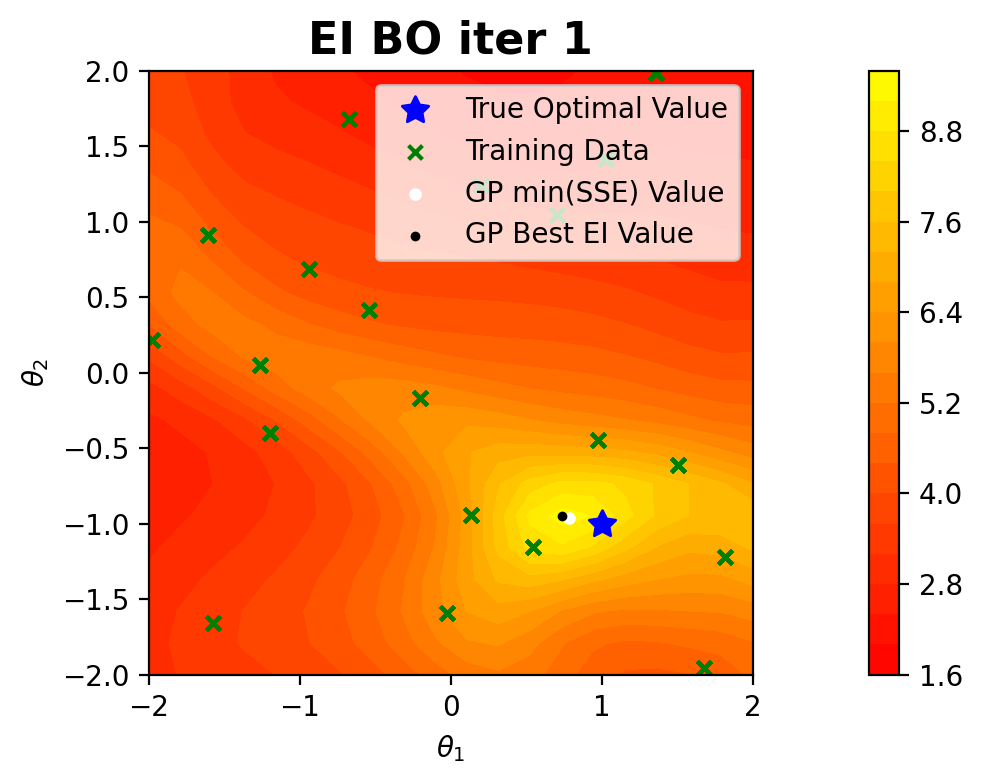

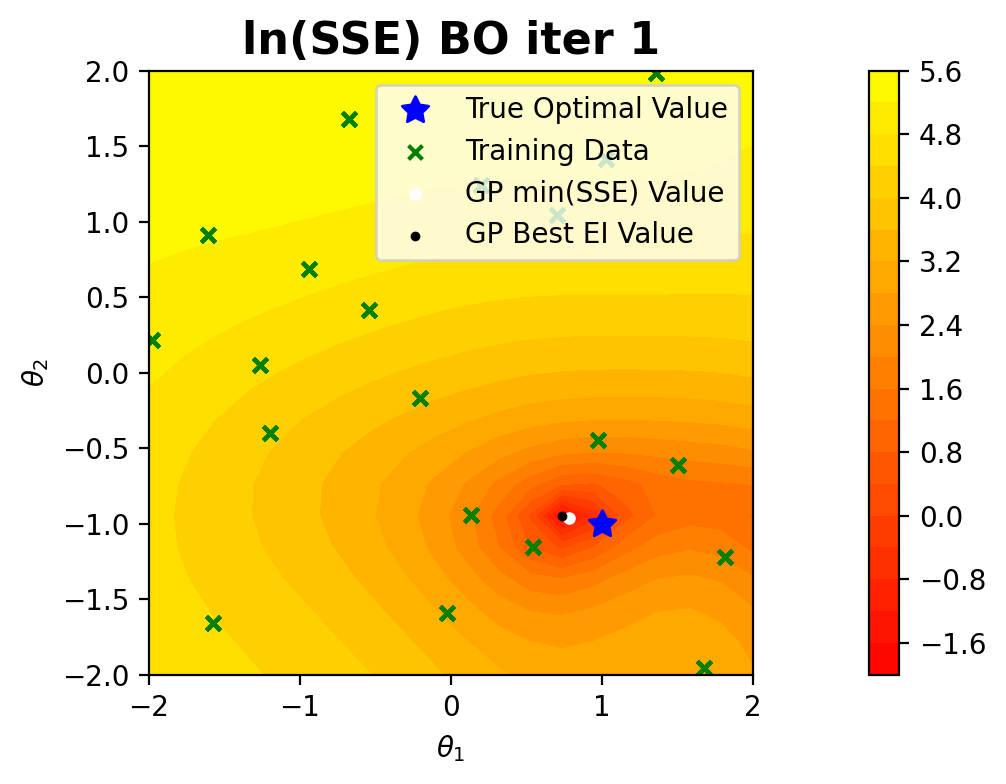

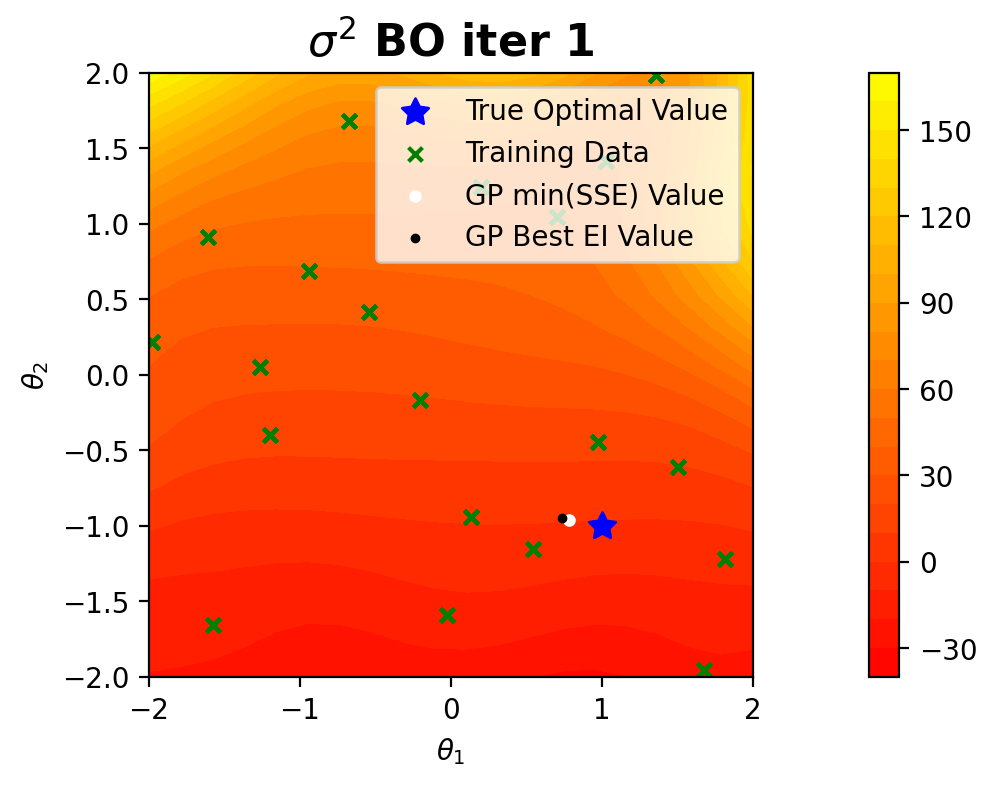

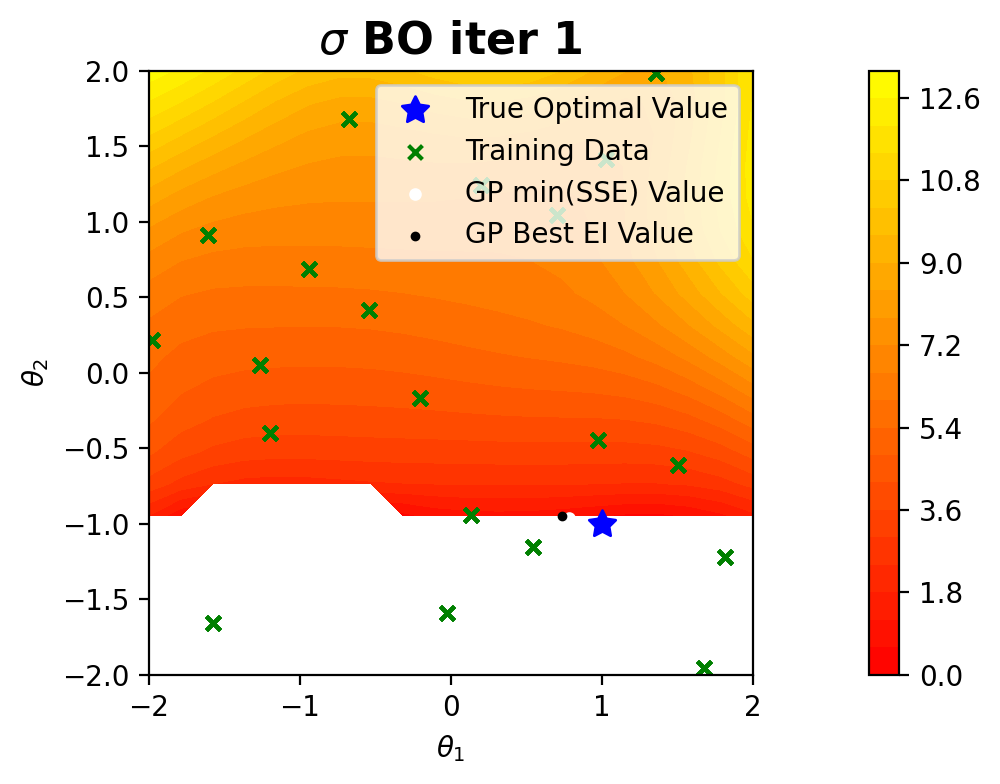

Best Error is: 2.8225
Magnitude of ln(SSE) given Theta_Opt =  [ 0.78260044 -0.96536034] is -7.0104e-01
[[0.42497188 0.49364585 0.55604446 0.6201883  0.72250479 0.85005605
  0.98285186 1.12750864 1.26798451 1.32291532 1.21031702 1.00444818
  0.84460008 0.76673418 0.73955923 0.75465763 0.83770794 0.97847712
  1.03944278 0.92191225]
 [0.42714095 0.51366073 0.57475501 0.61574727 0.72409654 0.89181542
  1.06652153 1.2579149  1.4595654  1.56221318 1.42278576 1.15650725
  0.97857767 0.89891756 0.86593467 0.88161314 0.97018218 1.10590136
  1.15526891 1.05104935]
 [0.40989837 0.50024366 0.56485766 0.57822984 0.6328339  0.77089757
  0.9456138  1.14789855 1.39640999 1.64832032 1.70615745 1.46439958
  1.21995687 1.12134016 1.08021057 1.08951139 1.18110728 1.33441055
  1.42438495 1.3260777 ]
 [0.38310781 0.4593406  0.52299994 0.53942108 0.55386293 0.61404634
  0.71877068 0.85339534 1.02797878 1.28400588 1.63455105 1.84403062
  1.65992713 1.45483804 1.44361663 1.5518769  1.69751573 1.74891448
  1.65

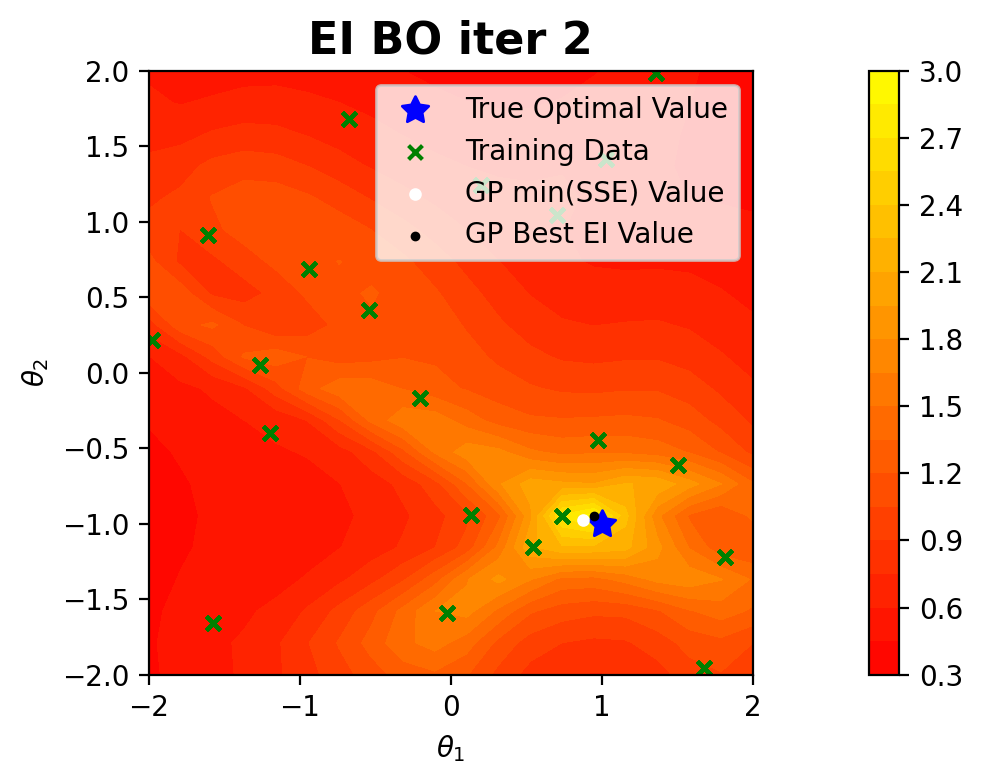

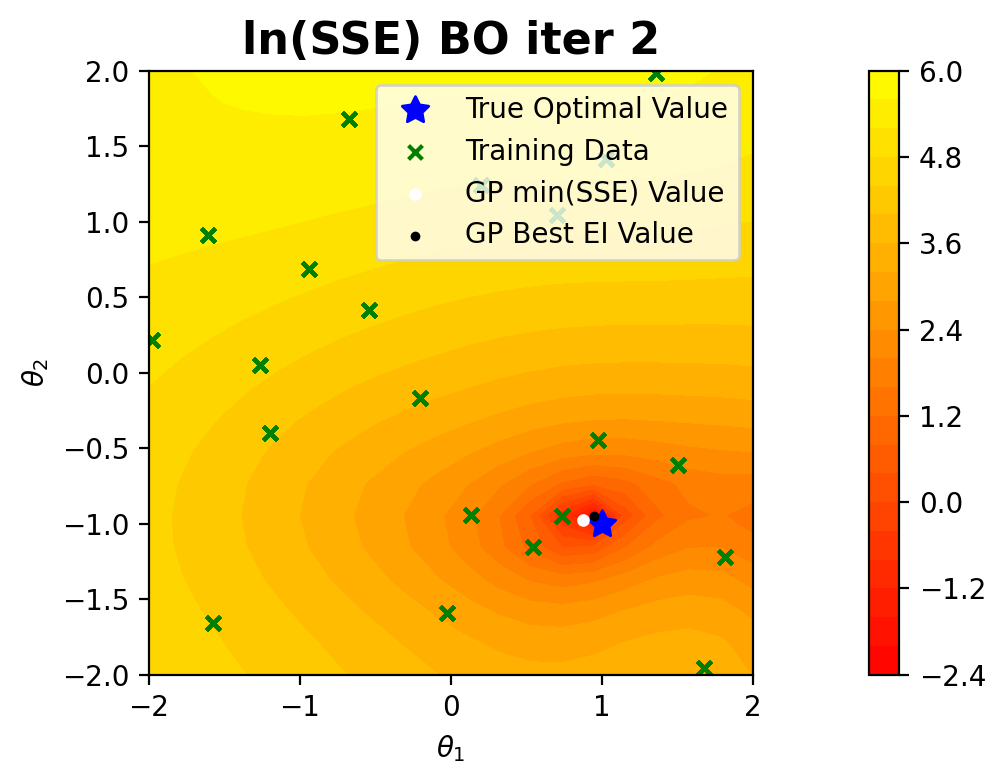

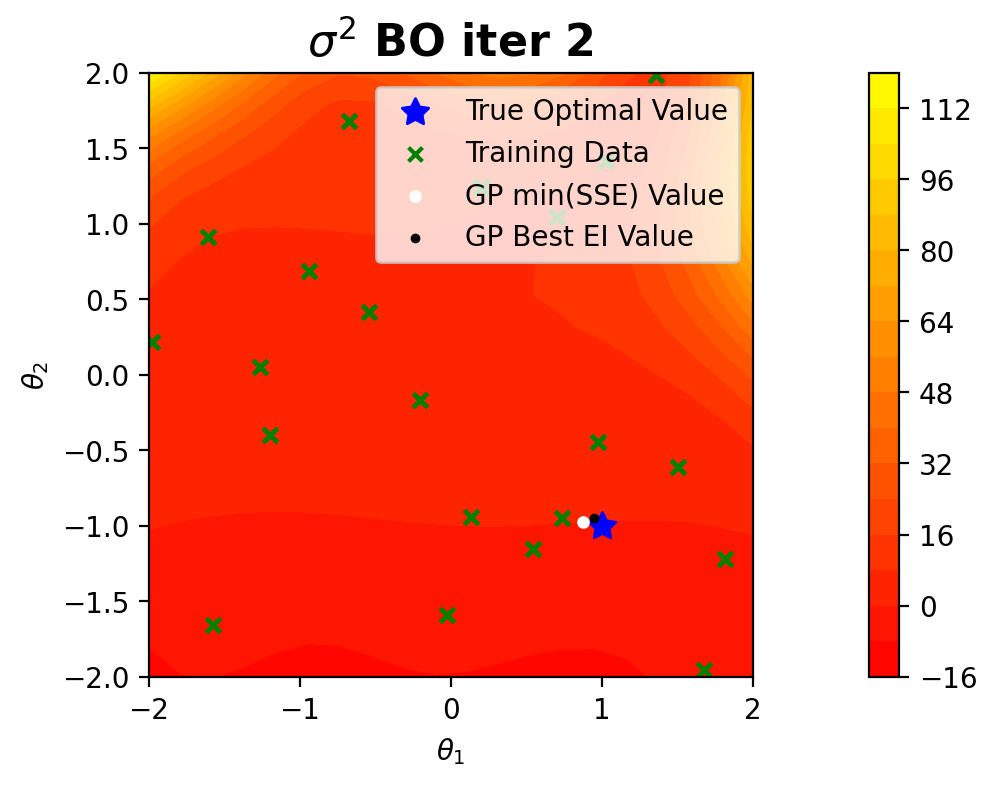

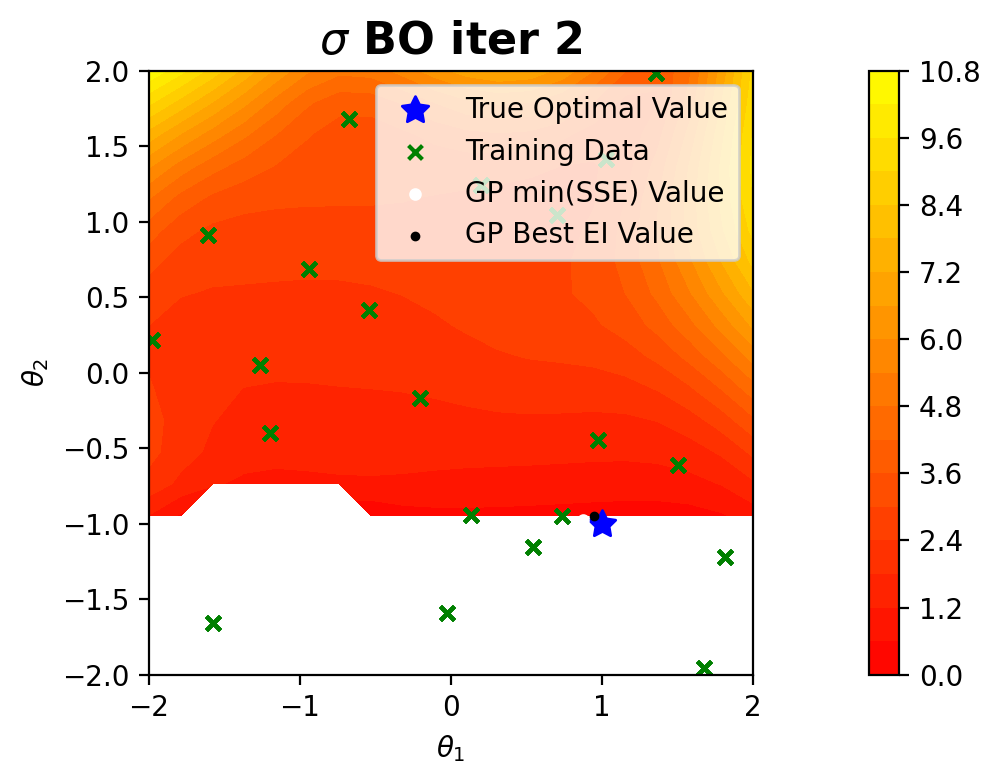

Best Error is: 0.768
Magnitude of ln(SSE) given Theta_Opt =  [ 0.8782082  -0.97763125] is -1.8538e+00
[[0.03333804 0.04516673 0.05086499 0.04774654 0.05610415 0.07653896
  0.09850527 0.12007447 0.13196521 0.12730008 0.11340647 0.09391232
  0.07784589 0.06725268 0.0625677  0.06769699 0.08598565 0.11917277
  0.15073128 0.11124835]
 [0.03740441 0.06362186 0.08752088 0.06829695 0.05742235 0.07384288
  0.10323656 0.13630241 0.15453687 0.15122095 0.16100752 0.13767658
  0.10632764 0.08395991 0.07562981 0.08468714 0.11210314 0.16496053
  0.19471614 0.12896073]
 [0.03675437 0.06248897 0.09833252 0.08287924 0.063636   0.06033465
  0.07509355 0.10721775 0.16417822 0.20683822 0.17465413 0.18093455
  0.15711114 0.11779772 0.09819443 0.11160634 0.14951864 0.1896977
  0.17448702 0.13873848]
 [0.0340456  0.05190303 0.07677583 0.07981846 0.0677707  0.06160383
  0.06295741 0.07139783 0.08647723 0.10767623 0.17410591 0.24721512
  0.2001261  0.18167575 0.14691502 0.15905891 0.18729705 0.23564987
  0.2125

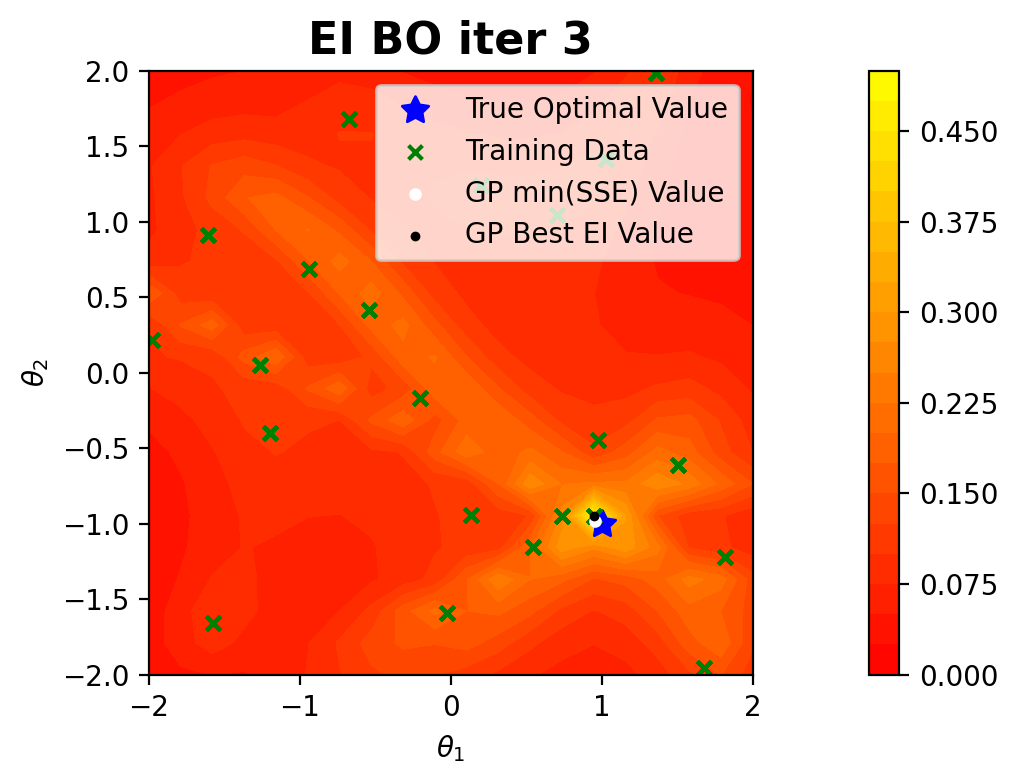

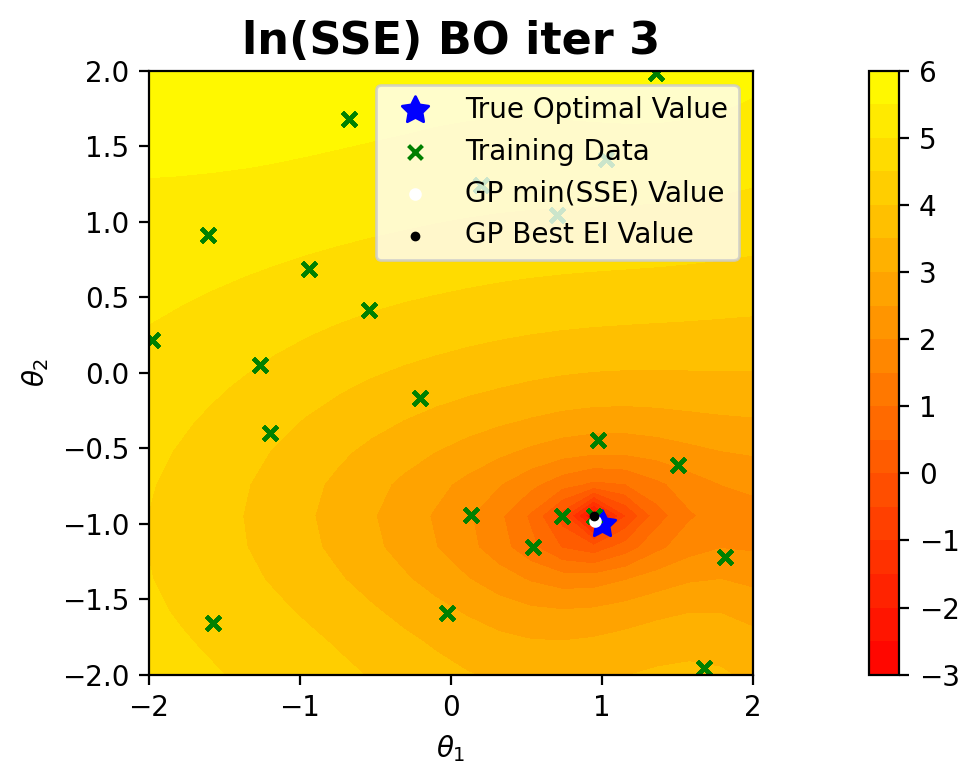

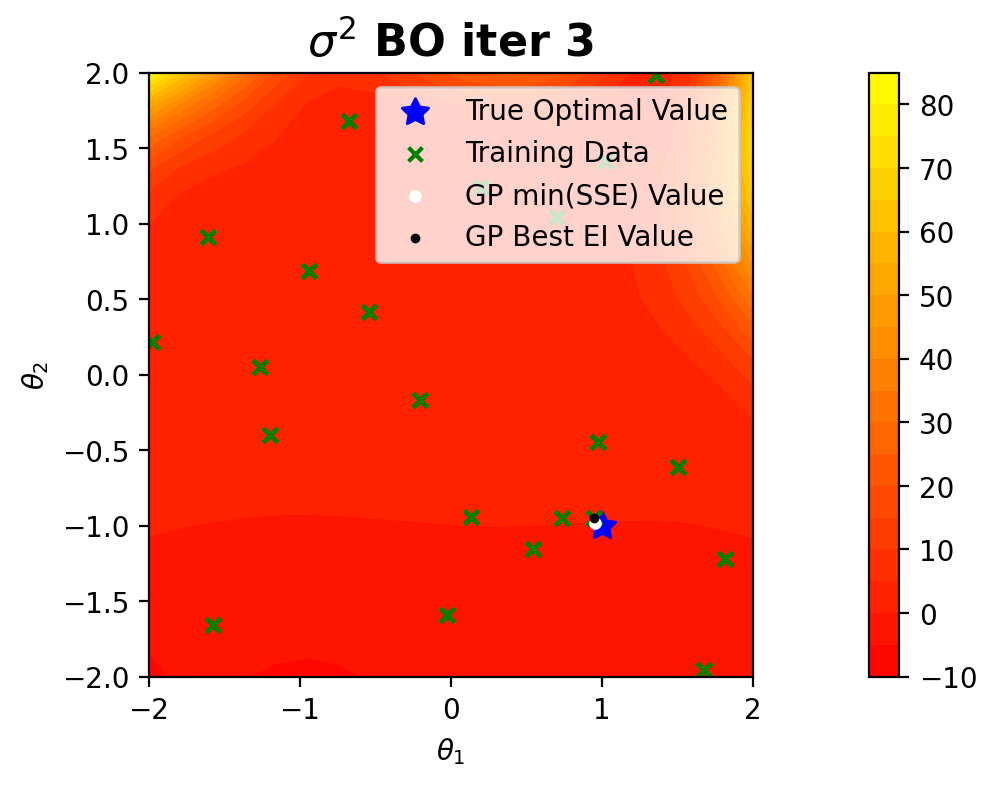

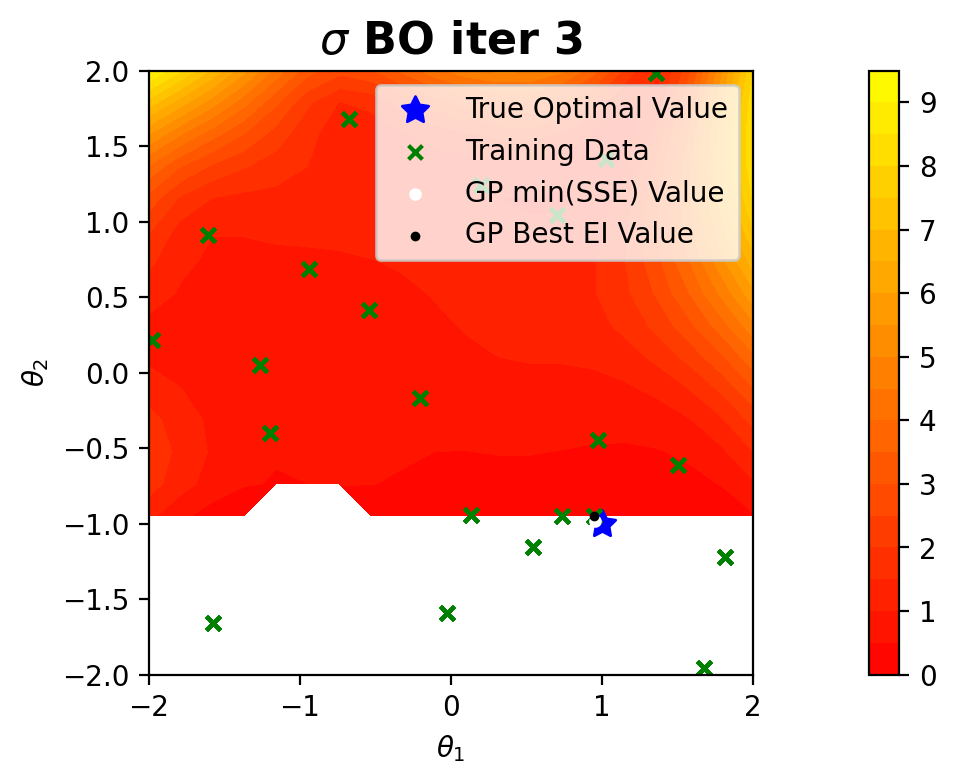

Best Error is: 0.1283
Magnitude of ln(SSE) given Theta_Opt =  [ 0.95530621 -0.985481  ] is -3.6548e+00


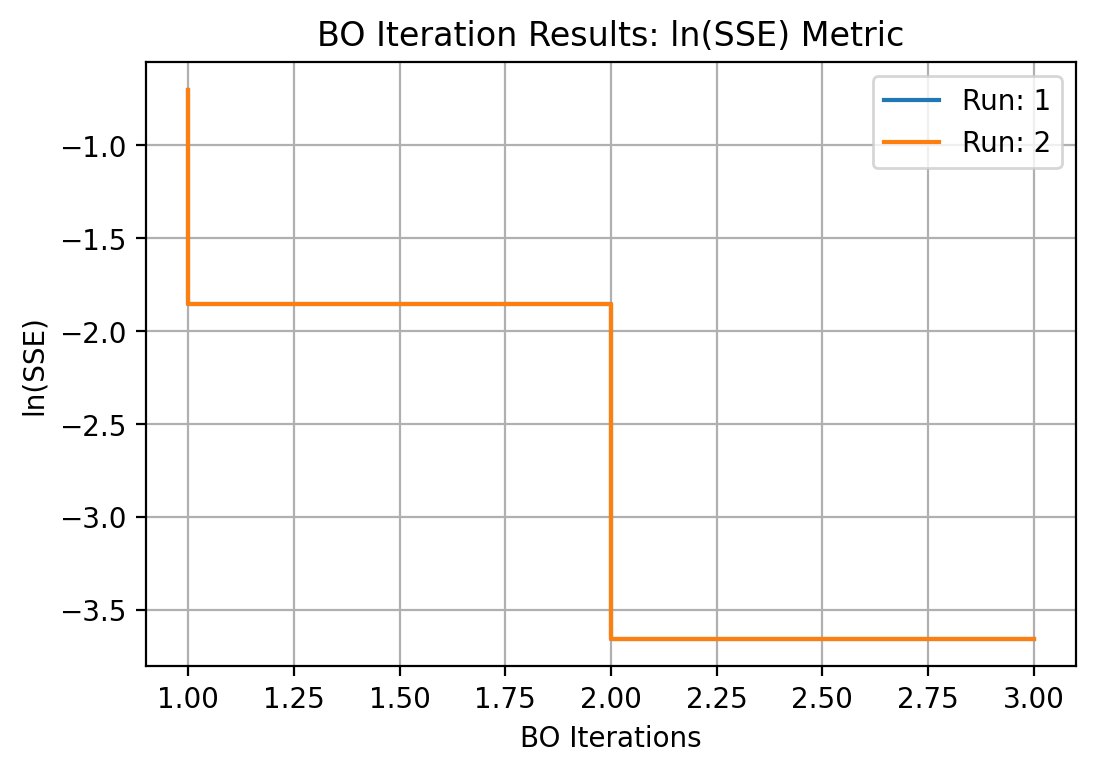

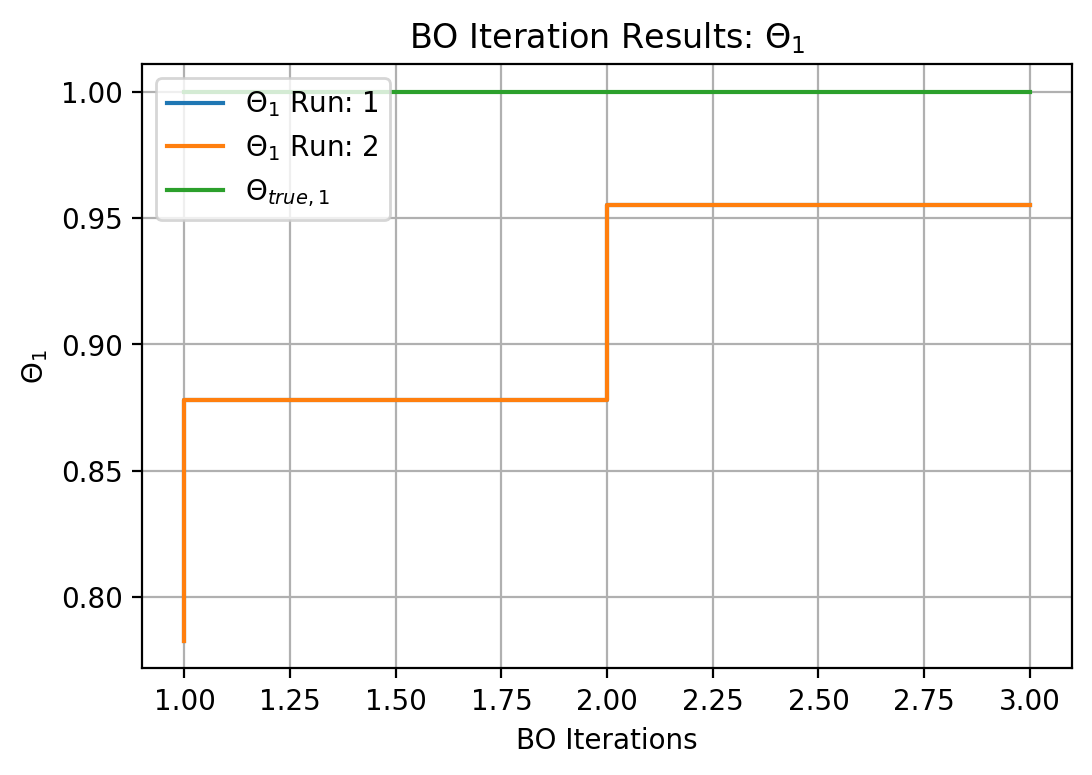

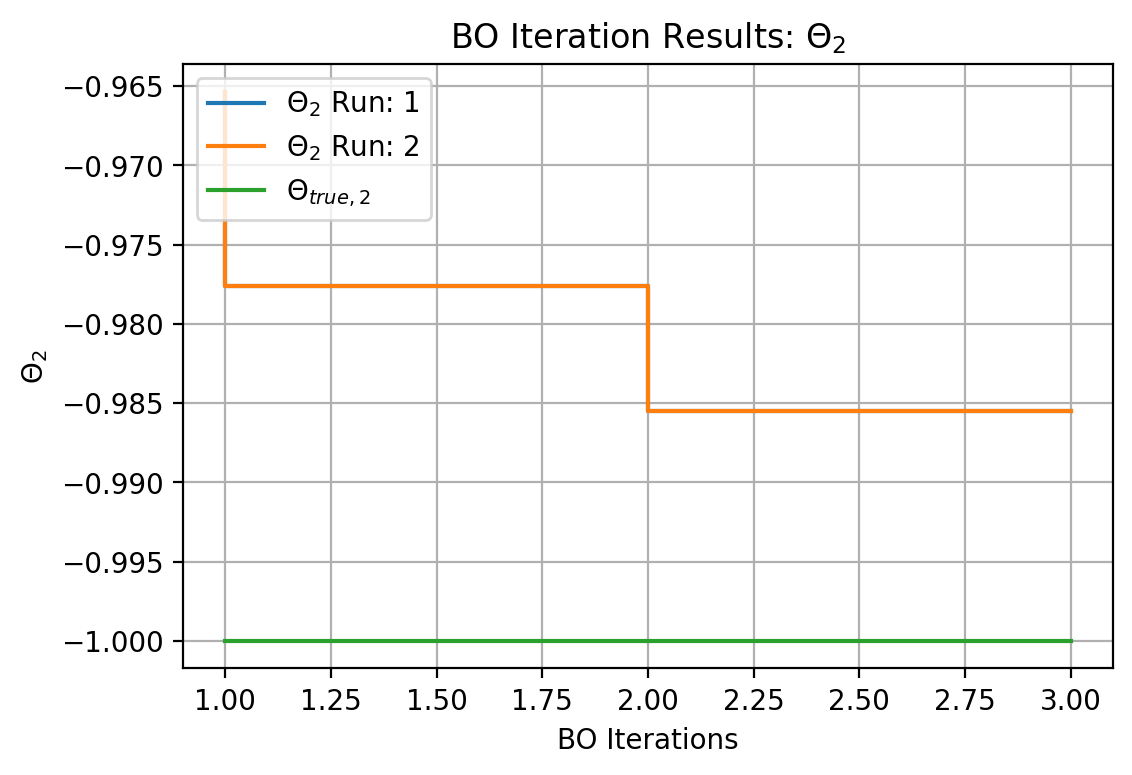

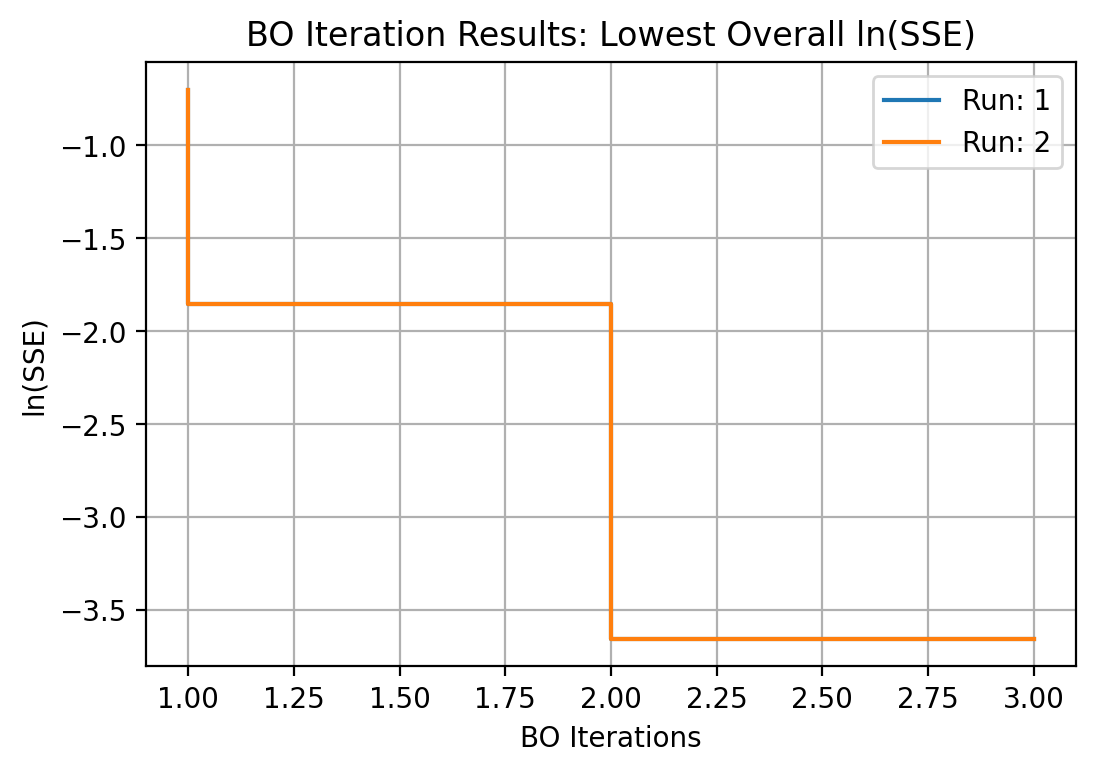

The GP predicts the lowest SSE of 2.587e-02 occurs at θ = [ 0.95530622 -0.985481  ] during run 1 at BO iteration 3
At this point, the highest EI occurs at θ = [ 0.94736842 -0.98488868]


CPU times: user 49.6 s, sys: 328 ms, total: 49.9 s
Wall time: 50.1 s


In [3]:
%%time
obj = "obj"

all_data_doc = find_train_doc_path(emulator, obj, t)
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=",")) 

print("Runs:", runs)
print("BO Iters:", BO_iters)
print("----------------------------------------------------")
print("Separation Factor Train/Test:", str(np.round(sep_fact,3)))
print("Lengthscale Set To:", set_lengthscale)
print("Initial Explore Bias:", str(np.round(float(explore_bias[0]),3)))
results = bo_iter_w_runs(BO_iters,all_data_doc,t,theta_mesh,Theta_True,train_iter,explore_bias[0], Xexp, Yexp,
                             noise_std, obj, runs, sparse_grid, emulator, set_lengthscale, verbose, 
                             save_fig, shuffle_seed, DateTime, sep_fact = sep_fact)
print("The GP predicts the lowest SSE of", "{:.3e}".format(np.exp(results[3])), "occurs at \u03B8 =", results[2][0], 
          "during run", results[1], "at BO iteration", results[0])
print("At this point, the highest EI occurs at \u03B8 =", results[4][0])
print("\n")